In [ ]:
#@title Copyright 2023 The Earth Engine Community Authors { display-mode: "form" }
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Change Detection in Google Earth Engine - The MAD Transformation (Part 3)
Author: mortcanty

Test of pixel intensities across different image acquisitions requires that the received signals have similar radiometric scales.
As we saw in [Part 2](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2) of the present tutorial, provided the iMAD algorithm converges satisfactorily, it will isolate the pixels
which have not significantly changed in the two input images presented to it. A regression analysis on these no-change
pixels can then determine how well the radiometric parameters of the two acquisitions compare.
If, for instance, images that were corrected to absolute surface reflectance are examined in this way, we would expect a good match, i.e., a
slope close to one and an intercept close to zero at all spectral wavelengths. In general,
for uncalibrated or poorly corrected images, this will not be the case. Then, the regression
coefficients can be applied to normalize one image (the target, say) to the other
(the reference). This is a prerequisite, for example, for tracing features such as NDVI indices over
a time series when the images have not been reduced to surface reflectances,
see e.g., [Gan et al. (2021)](https://ieeexplore.ieee.org/document/9392311), or indeed for
*harmonizing* the data from two different sensors of the same family, such as Landsat 8 with
Landsat 9. In this final part of the GEE Change Detection Tutorial we'll have a closer look at this approach, which we'll refer to here as *relative radiometric normalization*. For more detailed treatment, see also [Canty and Nielsen (2008)](https://www.sciencedirect.com/science/article/abs/pii/S0034425707003495), [Canty et al. (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0034425704001208), and [Schroeder et al. (2006)](https://www.sciencedirect.com/science/article/abs/pii/S0034425706001179). A different (but similar) method involving identification of so-called *pseudoinvariant features*
is explained in [another GEE community tutorial](https://developers.google.com/earth-engine/tutorials/community/pseudo-invariant-feature-matching) in this series.

## Preliminaries

This tutorial will optionally export assets. Edit the following
`EXPORT_PATH` variable to specify the location to store the assets.
All assets that are needed to complete the tutorial are hosted by Earth Engine,
but if you'd like to display assets that you export, replace paths as needed.

In [ ]:
# Enter your own export to assets path name here -----------
EXPORT_PATH = 'projects/YOUR_GEE_PROJECT_NAME/assets/imad/'
# ------------------------------------------------

In [4]:
import ee

ee.Authenticate(auth_mode='notebook')
ee.Initialize(project= 'ee-gsingh')

In [5]:
# Import other packages used in the tutorial
%matplotlib inline
import geemap
import numpy as np
import random, time
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

from pprint import pprint  # for pretty printing

In [6]:
#@title Routines from Parts 1 and 2

def trunc(values, dec = 3):
    '''Truncate a 1-D array to dec decimal places.'''
    return np.trunc(values*10**dec)/(10**dec)

# Display an image in a one percent linear stretch.
def display_ls(image, map, name, centered = False):
    bns = image.bandNames().length().getInfo()
    if bns == 3:
        image = image.rename('B1', 'B2', 'B3')
        pb_99 = ['B1_p99', 'B2_p99', 'B3_p99']
        pb_1 = ['B1_p1', 'B2_p1', 'B3_p1']
        img = ee.Image.rgb(
            image.select('B1'), image.select('B2'), image.select('B3'))
    else:
        image = image.rename('B1')
        pb_99 = ['B1_p99']
        pb_1 = ['B1_p1']
        img = image.select('B1')
    percentiles = image.reduceRegion(
        ee.Reducer.percentile([1, 99]), maxPixels=1e11)
    mx = percentiles.values(pb_99)
    if centered:
        mn = ee.Array(mx).multiply(-1).toList()
    else:
        mn = percentiles.values(pb_1)
    map.addLayer(img, {'min': mn, 'max': mx}, name)

def covarw(image, weights=None, scale=20, maxPixels=1e10):
    '''Return the centered image and its weighted covariance matrix.'''
    try:
        geometry = image.geometry()
        bandNames = image.bandNames()
        N = bandNames.length()
        if weights is None:
            weights = image.constant(1)
        weightsImage = image.multiply(ee.Image.constant(0)).add(weights)
        means = image.addBands(weightsImage) \
                    .reduceRegion(ee.Reducer.mean().repeat(N).splitWeights(),
                                scale=scale,
                                maxPixels=maxPixels) \
                    .toArray() \
                    .project([1])
        centered = image.toArray().subtract(means)
        B1 = centered.bandNames().get(0)
        b1 = weights.bandNames().get(0)
        nPixels = ee.Number(centered.reduceRegion(ee.Reducer.count(),
                                                scale=scale,
                                                maxPixels=maxPixels).get(B1))
        sumWeights = ee.Number(weights.reduceRegion(ee.Reducer.sum(),
                                                    geometry=geometry,
                                                    scale=scale,
                                                    maxPixels=maxPixels).get(b1))
        covw = centered.multiply(weights.sqrt()) \
                    .toArray() \
                    .reduceRegion(ee.Reducer.centeredCovariance(),
                                    geometry=geometry,
                                    scale=scale,
                                    maxPixels=maxPixels) \
                    .get('array')
        covw = ee.Array(covw).multiply(nPixels).divide(sumWeights)
        return (centered.arrayFlatten([bandNames]), covw)
    except Exception as e:
        print('Error: %s'%e)

def corr(cov):
    '''Transform covariance matrix to correlation matrix.'''
    # Diagonal matrix of inverse sigmas.
    sInv = cov.matrixDiagonal().sqrt().matrixToDiag().matrixInverse()
    # Transform.
    corr = sInv.matrixMultiply(cov).matrixMultiply(sInv).getInfo()
    # Truncate.
    return [list(map(trunc, corr[i])) for i in range(len(corr))]

def geneiv(C,B):
    '''Return the eigenvalues and eigenvectors of the generalized eigenproblem
       C*X = lambda*B*X'''
    try:
        C = ee.Array(C)
        B = ee.Array(B)
        #  Li = choldc(B)^-1
        Li = ee.Array(B.matrixCholeskyDecomposition().get('L')).matrixInverse()
        # Solve symmetric, ordinary eigenproblem Li*C*Li^T*x = lambda*x
        Xa = Li.matrixMultiply(C) \
            .matrixMultiply(Li.matrixTranspose()) \
            .eigen()
        # Eigenvalues as a row vector.
        lambdas = Xa.slice(1, 0, 1).matrixTranspose()
        # Eigenvectors as columns.
        X = Xa.slice(1, 1).matrixTranspose()
        # Generalized eigenvectors as columns, Li^T*X
        eigenvecs = Li.matrixTranspose().matrixMultiply(X)
        return (lambdas, eigenvecs)
    except Exception as e:
        print('Error: %s'%e)

# Collect a Sentinel-2 image pair.
def collect(aoi, t1a ,t1b, t2a, t2b, coll1, coll2 = None):
    try:
        if coll2 == None:
            coll2 = coll1
        im1 = ee.Image( ee.ImageCollection(coll1)
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t1a), ee.Date(t1b))
                               .filter(ee.Filter.contains(rightValue=aoi, leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .sort('CLOUD_COVER_LAND')
                               .first()
                               .clip(aoi) )
        im2 = ee.Image( ee.ImageCollection(coll2)
                               .filterBounds(aoi)
                               .filterDate(ee.Date(t2a), ee.Date(t2b))
                               .filter(ee.Filter.contains(rightValue=aoi, leftField='.geo'))
                               .sort('CLOUDY_PIXEL_PERCENTAGE')
                               .sort('CLOUD_COVER_LAND')
                               .first()
                               .clip(aoi) )
        timestamp = im1.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        timestamp = im2.date().format('E MMM dd HH:mm:ss YYYY')
        print(timestamp.getInfo())
        return (im1, im2)
    except Exception as e:
        print('Error: %s'%e)

#@title The iMAD code
def chi2cdf(Z,df):
    '''Chi-square cumulative distribution function with df degrees of freedom.'''
    return ee.Image(Z.divide(2)).gammainc(ee.Number(df).divide(2))

def imad(current,prev):
    '''Iterator function for iMAD.'''
    done =  ee.Number(ee.Dictionary(prev).get('done'))
    return ee.Algorithms.If(done, prev, imad1(current, prev))

def imad1(current,prev):
    '''Iteratively re-weighted MAD.'''
    image = ee.Image(ee.Dictionary(prev).get('image'))
    Z = ee.Image(ee.Dictionary(prev).get('Z'))
    allrhos = ee.List(ee.Dictionary(prev).get('allrhos'))
    nBands = image.bandNames().length().divide(2)
    weights = chi2cdf(Z,nBands).subtract(1).multiply(-1)
    scale = ee.Dictionary(prev).getNumber('scale')
    niter = ee.Dictionary(prev).getNumber('niter')
    # Weighted stacked image and weighted covariance matrix.
    centeredImage, covarArray = covarw(image, weights, scale)
    bNames = centeredImage.bandNames()
    bNames1 = bNames.slice(0, nBands)
    bNames2 = bNames.slice(nBands)
    centeredImage1 = centeredImage.select(bNames1)
    centeredImage2 = centeredImage.select(bNames2)
    s11 = covarArray.slice(0, 0, nBands).slice(1, 0, nBands)
    s22 = covarArray.slice(0, nBands).slice(1, nBands)
    s12 = covarArray.slice(0, 0, nBands).slice(1, nBands)
    s21 = covarArray.slice(0, nBands).slice(1, 0, nBands)
    c1 = s12.matrixMultiply(s22.matrixInverse()).matrixMultiply(s21)
    b1 = s11
    c2 = s21.matrixMultiply(s11.matrixInverse()).matrixMultiply(s12)
    b2 = s22
    # Solution of generalized eigenproblems.
    lambdas, A = geneiv(c1, b1)
    _, B       = geneiv(c2, b2)
    rhos = lambdas.sqrt().project(ee.List([1]))
    # Test for convergence.
    lastrhos = ee.Array(allrhos.get(-1))
    done = rhos.subtract(lastrhos) \
               .abs() \
               .reduce(ee.Reducer.max(), ee.List([0])) \
               .lt(ee.Number(0.0001)) \
               .toList() \
               .get(0)
    allrhos = allrhos.cat([rhos.toList()])
    # MAD variances.
    sigma2s = rhos.subtract(1).multiply(-2).toList()
    sigma2s = ee.Image.constant(sigma2s)
    # Ensure sum of positive correlations between X and U is positive.
    tmp = s11.matrixDiagonal().sqrt()
    ones = tmp.multiply(0).add(1)
    tmp = ones.divide(tmp).matrixToDiag()
    s = tmp.matrixMultiply(s11).matrixMultiply(A).reduce(ee.Reducer.sum(), [0]).transpose()
    A = A.matrixMultiply(s.divide(s.abs()).matrixToDiag())
    # Ensure positive correlation.
    tmp = A.transpose().matrixMultiply(s12).matrixMultiply(B).matrixDiagonal()
    tmp = tmp.divide(tmp.abs()).matrixToDiag()
    B = B.matrixMultiply(tmp)
    # Canonical and MAD variates.
    centeredImage1Array = centeredImage1.toArray().toArray(1)
    centeredImage2Array = centeredImage2.toArray().toArray(1)
    U = ee.Image(A.transpose()).matrixMultiply(centeredImage1Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames1])
    V = ee.Image(B.transpose()).matrixMultiply(centeredImage2Array) \
                   .arrayProject([0]) \
                   .arrayFlatten([bNames2])
    iMAD = U.subtract(V)
    # Chi-square image.
    Z = iMAD.pow(2) \
              .divide(sigma2s) \
              .reduce(ee.Reducer.sum())
    return ee.Dictionary({'done': done, 'scale': scale, 'niter': niter.add(1),
                          'image': image, 'allrhos': allrhos, 'Z': Z, 'iMAD': iMAD})

#@title Run iMAD algorithm as export task
def run_imad(aoi, image1, image2, assetId, scale=10, maxiter=100):
    try:
        N = image1.bandNames().length().getInfo()
        imadnames = ['iMAD'+str(i+1) for i in range(N)]
        imadnames.append('Z')
        # Maximum iterations.
        inputlist = ee.List.sequence(1, maxiter)
        first = ee.Dictionary({'done':0,
                            'scale': scale,
                            'niter': ee.Number(0),
                            'image': image1.addBands(image2),
                            'allrhos': [ee.List.sequence(1, N)],
                            'Z': ee.Image.constant(0),
                            'iMAD': ee.Image.constant(0)})
        # Iteration.
        result = ee.Dictionary(inputlist.iterate(imad, first))
        # Retrieve results.
        iMAD = ee.Image(result.get('iMAD')).clip(aoi)
        rhos = ee.String.encodeJSON(ee.List(result.get('allrhos')).get(-1))
        Z = ee.Image(result.get('Z'))
        niter = result.getNumber('niter')
        # Export iMAD and Z as a singe image, including rhos and number of iterations in properties.
        iMAD_export = ee.Image.cat(iMAD, Z).rename(imadnames).set('rhos', rhos, 'niter', niter)
        assexport = ee.batch.Export.image.toAsset(iMAD_export,
                        description='assetExportTask',
                        assetId=assetId, scale=scale, maxPixels=1e10)
        assexport.start()
        print('Exporting iMAD to %s\n task id: %s'%(assetId, str(assexport.id)))
    except Exception as e:
        print('Error: %s'%e)

### Relative radiometric normalization

We  will illustrate the idea with the German administrative district scene used in the first two parts of this tutorial ([Part 1](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt1), [Part 2](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2)), the Landkreis Olpe. Once we have isolated what we think to be the no-change pixels for two different Sentinel-2 acquisitions in the aoi, we can perform a regression analysis on them to determine how well their radiometric parameters compare *relative* to the identified no-change pixels in the two scenes. Clearly, both variables involved have measurement uncertainty associated with them. In fact, which acquisition is termed reference and which is termed target data is arbitrary. Therefore it is preferable to use *orthogonal linear regression* rather than ordinary linear regression. The former method treats the data symmetrically whereas the latter assumes uncertainty only in the dependent variable.

Orthogonal linear regression on two variables is explained in detail in the Appendix of [Canty et al. (2004)](https://www.sciencedirect.com/science/article/abs/pii/S0034425704001208), but can be briefly summarized as follows: let the no-change observations in a given spectral band of the reference and target images be $X_i$ and $Y_i, \ i=1\dots n$, respectively. Then define the $n\times 2$ *data matrix*

$$
d = \begin{pmatrix} X_1 & Y_1\cr X_2 & Y_2 \cr \vdots & \vdots \cr X_n & Y_n\end{pmatrix},
$$

and calculate from it the mean values $\bar X,\ \bar Y$ and the covariance matrix

$$
\Sigma =\begin{pmatrix} \sigma^2_X & \sigma_{XY} \cr \sigma_{YX}\ & \sigma^2_Y\end{pmatrix}.
$$

The best estimates for the slope $b$ and intercept $a$ of the orthogonal regression line

$$
Y = bX+a
$$

are then given by

$$
\hat b = {\sigma^2_X -\sigma^2_Y + \sqrt{(\sigma^2_X -\sigma^2_Y)^2+4\sigma^2_{XY}}\over 2\sigma_{XY}}, \quad \hat a = \bar Y - b\bar X.
$$

As a simple quality criterion we can use the correlation coefficient

$$\rho = {\sigma_{XY}\over \sigma_X\sigma_Y}$$

which has value one for a perfect fit.

The following cell codes a function to iterate orthogonal regression over all of the spectral bands of an image pair.

In [7]:
def orthoregress(current, prev):
    '''
    Iterator function for orthogonal regression
    '''
    k = ee.Number(current)
    prev = ee.Dictionary(prev)
    # Image is concatenation of reference and target.
    image = ee.Image(prev.get('image'))
    coeffs = ee.List(prev.get('coeffs'))
    N = image.bandNames().length().divide(2)
    # Data matrix.
    d = image.select(k, k.add(N))
    means = d.reduceRegion(ee.Reducer.mean(), scale=10, maxPixels=1e10) \
                  .toArray() \
                  .project([0])
    Xm = means.get([0])
    Ym = means.get([1])
    Sigma = ee.Array(d.toArray() \
              .reduceRegion(ee.Reducer.covariance(), scale=10, maxPixels=1e10) \
              .get('array'))
    Sxx = Sigma.get([0, 0])
    Syy = Sigma.get([1, 1])
    Sxy = Sigma.get([0, 1])
    # Correlation.
    rho = Sxy.divide(Sxx.multiply(Syy).sqrt())
    # Orthoregress reference onto target.
    b = Syy.subtract(Sxx) \
           .add(Syy.subtract(Sxx).pow(2).add(Sxy.pow(2).multiply(4)).sqrt()) \
           .divide(Sxy.multiply(2))
    a = Ym.subtract(b.multiply(Xm))
    coeffs = coeffs.add(ee.List([b, a, rho]))
    return ee.Dictionary({'image': image, 'coeffs': coeffs})

def normalize(ref, target, imad_path, pmin=0.9, bandNames=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']):
    '''
    Relative radiometric normalization of target to reference
    using iMAD for 6-band visual/infrared images

    Args:
    - ref: Reference image
    - target: Target image
    - imad_path: Asset path of iMAD image
    - pmin: Minimum p-value for identifying no change
    - bandNames: Band names (default: S2 visual/infrared)

    Returns:
    - Tuple containing normalized target, coefficients, image stack, and no-change mask
    '''
    try:
        # Get iMAD result and mask out water surfaces.
        waterMask = ee.Image('UMD/hansen/global_forest_change_2015').select('datamask').eq(1)
        res = ee.Image(imad_path).updateMask(waterMask)
        # iMAD image.
        imad = res.select(0, 1, 2, 3, 4, 5)
        # chi-square test statistic.
        z = res.select(6).rename('Z')
        niter = imad.get('niter').getInfo()
        rhos = ee.List(imad.get('rhos')).getInfo()
        print('iMAD result:')
        print('iterations: %i'%niter)
        print('canonical correlations: %s'%rhos)
        print('orthogonal regression:')
        # p-values.
        pval = chi2cdf(z, 6).subtract(1).multiply(-1).rename('pval')
        # no-change mask using p-values greater than pmin.
        noChangeMask = pval.gt(pmin)
        # Stack (concatenate) the reference and target images.
        im_stack = ee.Image.cat(ref, target).clip(aoi).updateMask(noChangeMask)
        # iterate ortho regression over spectral bands.
        first = ee.Dictionary({'image': im_stack, 'coeffs': ee.List([])})
        result = ee.Dictionary(ee.List.sequence(0, 5).iterate(orthoregress, first))
        # Display results.
        coeffs = np.array(result.get('coeffs').getInfo())
        print('          Slope        Intercept      Rho')
        pprint(coeffs)
        a = coeffs[:, 1].tolist()
        b = coeffs[:, 0].tolist()
        # Normalize target:  Y = b X + a => X = (Y - a) / b
        target_norm = target.subtract(ee.Image.constant(a)).divide(ee.Image.constant(b)).rename(bandNames)
        return (target_norm, coeffs, im_stack, noChangeMask)
    except ee.EEException as e:
        print("Error:", e)
        return (None, None, None, None)

### A Slightly Artificial Example

As a first illustration, we collect two minimally cloudy Sentinel-2 images over the Landkreis Olpe aoi from June, 2022 using the *collect* function from [Part 2](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2), capturing both SR and TOA reflectances:

In [8]:
# Landkreis Olpe.
aoi = ee.FeatureCollection(
    'projects/google/imad_tutorial/landkreis_olpe_aoi').geometry()

# Spectral band combinations
#Sentinel-2
visirbands = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
visnirbands = ['B8','B3','B2']
visbands = ['B2', 'B3', 'B4']
irbands = ['B8', 'B11', 'B12']
rededgebands = ['B5', 'B6', 'B7', 'B8A']
visnirparams = {'min': [0,0,0], 'max': [6000,1500,1500]}
visparams = {'min': [0,0,0], 'max': [1500,1500,1500]}
# Landsat-9 surface reflectance
visirbands_ls = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
visnirbands_ls = ['SR_B5','SR_B3','SR_B2']
# Rescale LS-9 SR to Sentinel-2 SR
def rescale_ls(image):
    return image.select(1,2,3,4,5,6).multiply(0.0000275).add(-0.2).multiply(10000)

In [9]:
im1_sr, im2_toa = collect(aoi, '2022-06-15', '2022-06-17', '2022-06-22', '2022-06-24', 'COPERNICUS/S2_SR_HARMONIZED', coll2 = 'COPERNICUS/S2_HARMONIZED')

Thu Jun 16 10:46:56 2022
Thu Jun 23 10:37:00 2022


Now we will do a relative radiometric normalization of the TOA image to the SR image. This is obviously a constructed example, as the target image, corrected to surface reflectance, is already available.

First we require the iMAD result which is produced by the following export task. However, Earth Engine
provides the asset for use in this demo, so it is not required that you run the
export cell to complete the tutorial.

In [ ]:
asset_path = f'{EXPORT_PATH}MAD_Im1_sr_Im2_toa'
run_imad(aoi, im1_sr.select(visirbands), im2_toa.select(visirbands), asset_path)

After the iMAD export is finished (monitor progress at [https://code.earthengine.google.com/tasks](https://code.earthengine.google.com/tasks), if you ran the export cell), updated the `imad_asset_path` below or continue to use the Earth Engine copy and run the cell to apply the normalization procedure, choosing a minimum p-value of 0.9 (the default) for the no change pixels.

In [10]:
target = im2_toa.select(visirbands)
reference = im1_sr.select(visirbands)
imad_asset_path = 'projects/google/imad_tutorial/MAD_Im1_sr_Im2_toa'

# Change the iMAD image path as needed. Here we use Earth Engine's asset.
im2_toa_norm, coeffs, im_stack, noChangeMask = normalize(
    reference, target, imad_asset_path)

# No-change image.
nc = ee.Image.constant(1).clip(aoi).updateMask(noChangeMask)

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\ee\deprecation.py:207: DeprecationWarning: 

Attention required for UMD/hansen/global_forest_change_2015! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2015

  warnings.warn(warning, category=DeprecationWarning)


iMAD result:
iterations: 55
canonical correlations: [0.9962911580327083,0.9939077628476969,0.973485998677739,0.9382149017221215,0.8926650749941412,0.733742800381792]
orthogonal regression:
          Slope        Intercept      Rho
array([[  0.81309867, 691.93588492,   0.96608128],
       [  0.78237873, 442.69252666,   0.98327486],
       [  0.92497782, 256.47932175,   0.991671  ],
       [  0.84986581, 372.00351353,   0.99695427],
       [  1.01512063,  88.62810783,   0.99700816],
       [  0.93578682,  31.90432218,   0.99676102]])


The $\rho$ values are all $>0.96$ indicating well-defined regressions. Here we have a look at them:

In [11]:
def plot_orthoregress(coeffs, im_stack, bandNames=visirbands, aoi=None):
    '''Plot the regression fits for 6 spectral bands.'''
    fig, ax = plt.subplots(2, 3, figsize=(12, 8))
    a = coeffs[:, 1].tolist()
    b = coeffs[:, 0].tolist()

    for i in range(3):
        # Visual bands.
        try:
            d = np.array(ee.Array(im_stack.select(i, 6 + i)
                                  .reduceRegion(ee.Reducer.toList(2), geometry=aoi, scale=10, maxPixels=1e10)
                                  .get('list')).getInfo())
            ax[0, i].plot(d[:, 0], d[:, 1], '.', label=bandNames[i])
            ax[0, i].set_ylim(-50, 2000)
            ax[0, i].set_xlim(-50, 2000)
            ax[0, i].plot([-50, 2000], [a[i] - 50 * b[i], a[i] + 2000 * b[i]], '-r', label='ortho regression')
            ax[0, i].legend()
            ax[0, i].grid()
        except ee.EEException as e:
            print("Error fetching visual band data:", e)

        # IR bands.
        try:
            d = np.array(ee.Array(im_stack.select(i + 3, 9 + i)
                                  .reduceRegion(ee.Reducer.toList(2), geometry=aoi, scale=10, maxPixels=1e10)
                                  .get('list')).getInfo())
            ax[1, i].plot(d[:, 0], d[:, 1], '.', label=bandNames[i + 3])
            ax[1, i].set_ylim(-50, 6000)
            ax[1, i].set_xlim(-50, 6000)
            ax[1, i].plot([-50, 6000], [a[i + 3] - 50 * b[i + 3], a[i + 3] + 6000 * b[i + 3]], '-r', label='ortho regression')
            ax[1, i].legend()
            ax[1, i].grid()
        except ee.EEException as e:
            print("Error fetching IR band data:", e)

    plt.show()

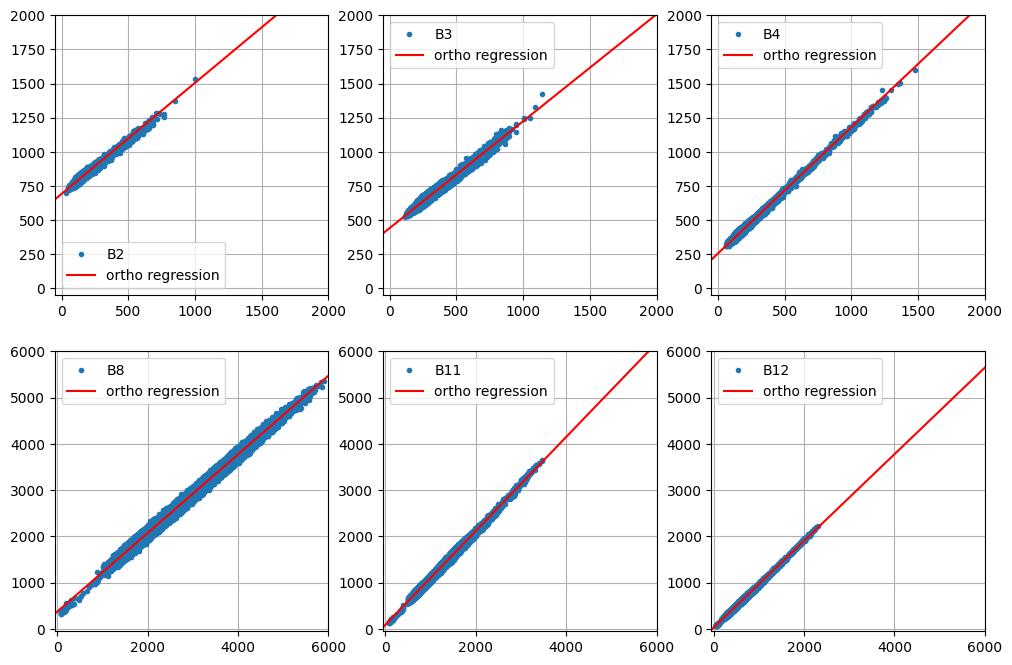

In [12]:
plot_orthoregress( coeffs, im_stack )

The next cell compares the normalized and unnormalized TOA images with the reference SR image. The no-change pixels used in the regression are also displayed:

In [13]:
M1 = geemap.Map()
M1.centerObject(aoi, 13)
M1.addLayer(im1_sr.select(visnirbands), visnirparams, 'Im1_sr')
M1.addLayer(im2_toa.select(visnirbands), visnirparams, 'Im2_toa')
M1.addLayer(im2_toa_norm.select(visnirbands), visnirparams, 'Im2_toa_norm')
M1.addLayer(nc,{'min': 0, 'max': 1, 'palette': ['yellow']}, 'no change')

M1

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

As we might expect, comparison of the NDVI indices is meaningful after the radiometric normalization, but not before:

In [14]:
def ndvi_s2(im):
    '''Sentinel-2 NDVI.'''
    return im.select('B8').subtract(im.select('B4')).divide(
        im.select('B8').add(im.select('B4')))

In [15]:
M2 = geemap.Map()
M2.centerObject(aoi, 13)
M2.addLayer(ndvi_s2(im1_sr), {'min': 0, 'max': 1.2, 'palette': ['black', 'yellow']}, 'Im1_ndvi')
M2.addLayer(ndvi_s2(im2_toa_norm), {'min': 0, 'max': 1.2, 'palette': ['black', 'yellow']}, 'Im2_toa_norm_ndvi')
M2.addLayer(ndvi_s2(im2_toa), {'min': 0, 'max': 1.2, 'palette': ['black', 'yellow']}, 'Im2_toa_ndvi')

M2

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

### A More Realistic Example

Top of atmosphere reflectance images are available for Sentinel-2 from 2015-06-23, surface reflectance images only from 2017-03-28. So we might attempt to normalize historical TOA images to their earliest SR counterparts. Here, for example, we gather an SR image from May, 2017 and a TOA image from May, 2016:

In [16]:
im1_sr, im2_toa = collect(aoi, '2017-05-01', '2017-05-31', '2016-05-01', '2016-05-31', 'COPERNICUS/S2_SR_HARMONIZED', coll2='COPERNICUS/S2_HARMONIZED')

Wed May 10 10:30:25 2017
Sun May 08 10:40:27 2016


Again we first run the iMAD algorithm on the two images. (It is optional to run the task in this demo; the asset that is generated is provided by Earth Engine and imported by defaulyt later in the tutorial)

In [ ]:
asset_path = f'{EXPORT_PATH}MAD_Im1_sr_Im1_toa'
run_imad(aoi, im1_sr.select(visirbands), im2_toa.select(visirbands), asset_path, maxiter=200)

Perform the orthogonal regression on the invariant pixels. (The following cell uses Earth Engine's copy of the exported asset, update the path if you completed the export task and prefer to use your copy)

In [17]:
target = im2_toa.select(visirbands)
reference = im1_sr.select(visirbands)

# Change the iMAD image path as needed. Here we use Earth Engine's asset.
imad_asset_path = 'projects/google/imad_tutorial/MAD_Im1_sr_Im1_toa'

im2_toa_norm, coeffs, im_stack, noChangeMask = normalize(
    reference, target, imad_asset_path)

# No-change image.
nc = ee.Image.constant(1).clip(aoi).updateMask(noChangeMask)

iMAD result:
iterations: 116
canonical correlations: [0.9788037307215705,0.9623036622085586,0.7675674615817298,0.69348769549382,0.6247868148926123,0.4551084766704083]
orthogonal regression:
          Slope        Intercept      Rho
array([[  0.68664909, 631.79125715,   0.90532961],
       [  0.69981886, 379.01718799,   0.9629185 ],
       [  0.78308269, 213.5314547 ,   0.94080501],
       [  0.84859266,   6.12569729,   0.97992413],
       [  0.9574861 , -77.92251406,   0.97503978],
       [  0.8702266 , -26.34646559,   0.96621236]])


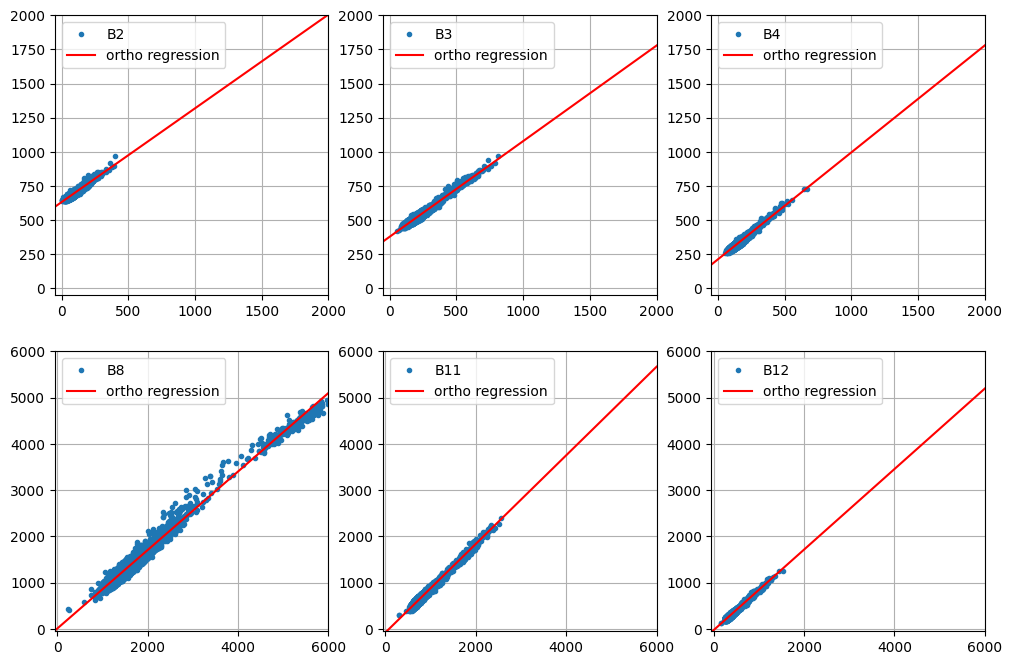

In [18]:
plot_orthoregress(coeffs, im_stack)

The above plot for the NIR band B8 is interesting as it seems to indicate that the surface reflectance correction is slightly nonlinear.
In any case, the regression plots look reasonable, so here again is the comparison of the normalized and unnormalized TOA images with the reference SR image:

In [19]:
M3 = geemap.Map()
M3.centerObject(aoi, 13)
M3.addLayer(im1_sr.select(visnirbands), visnirparams, 'Im1_sr')
M3.addLayer(im2_toa.select(visnirbands), visnirparams, 'Im1_toa')
M3.addLayer(im2_toa_norm.select(visnirbands), visnirparams, 'Im2_toa_norm')
M3.addLayer(nc,{'min': 0, 'max': 1, 'palette': ['yellow']}, 'no change')

M3

Map(center=[51.08617675675536, 7.976478425048881], controls=(WidgetControl(options=['position', 'transparent_b…

### Harmonization

The term *harmonization*, with reference to Sentinel-2 data, has a special meaning, see [the note](https://developers.google.com/earth-engine/datasets/catalog/sentinel-2)  in the GEE data catalogue. However, here we'll use it to characterize relative radiometric normalization across two different remote sensing satellite missions.

Landsat-9 surface reflectance images are available from October, 2021, Landsat-8 SR from March, 2013. Paralleling our investigation of clear cutting in [Part 2](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2), we gather a cloud-free Landsat-8 image from March 30, 2021 and a Landsat-9 acquisition from March 9, 2022, likewise cloud-free. For convenience, the reflectances are rescaled to the same range $[0,10000]$ as for Sentinel-2.

In [20]:
im_ls8, im_ls9 = collect(aoi, '2021-03-29', '2021-03-31', '2022-03-08', '2022-03-10', 'LANDSAT/LC08/C02/T1_L2', coll2='LANDSAT/LC09/C02/T1_L2')
im_ls8 = rescale_ls(im_ls8)
im_ls9 = rescale_ls(im_ls9)

Tue Mar 30 10:21:16 2021
Wed Mar 09 10:21:31 2022


Optionally run the iMAD algorithm or skip for the demo and use Earth Engine's copy of the result.

In [ ]:
asset_path = f'{EXPORT_PATH}MAD_Im_ls8_Im_ls9'
run_imad(aoi, im_ls8.select(visirbands_ls), im_ls9.select(visirbands_ls), asset_path, scale=30, maxiter=200)

Perform the normalization (or rather, the harmonization). (The following cell uses Earth Engine's copy of the exported asset, update the path if you completed the export task and prefer to use your copy)

In [21]:
target = im_ls8.select(visirbands_ls)
reference = im_ls9.select(visirbands_ls)

# Change the iMAD image path as needed. Here we use Earth Engine's asset.
imad_asset_path = 'projects/google/imad_tutorial/MAD_Im_ls8_Im_ls9'

im_ls8_norm, coeffs, im_stack, noChangeMask = normalize(reference, target, imad_asset_path, pmin=0.9, bandNames=visirbands_ls)

# No-change image.
nc = ee.Image.constant(1).clip(aoi).updateMask(noChangeMask)

iMAD result:
iterations: 39
canonical correlations: [0.9933014385513874,0.9792572713542846,0.92833667420112,0.862596267514323,0.8190016125288903,0.8002150414634657]
orthogonal regression:
          Slope        Intercept      Rho
array([[  1.03766941,  33.03708593,   0.98883645],
       [  1.01143874,  45.80300849,   0.99367202],
       [  1.04955523,  35.67312078,   0.99482327],
       [  0.83321303, 224.78213871,   0.98303965],
       [  1.05879735,  81.43020496,   0.99410074],
       [  1.09551231,  37.77021016,   0.99472014]])


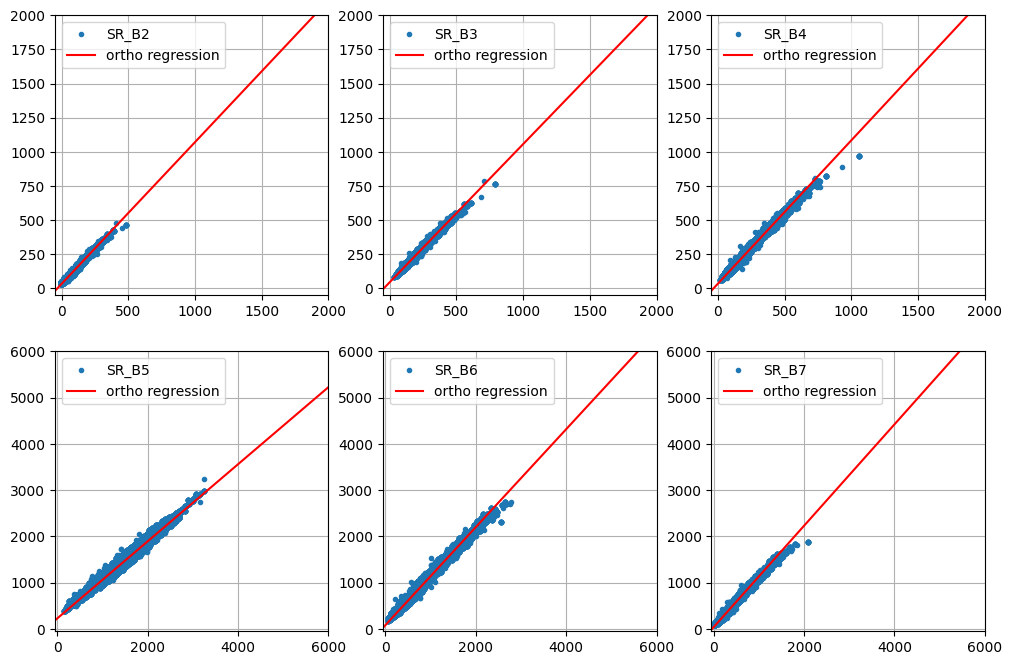

In [22]:
plot_orthoregress(coeffs, im_stack, bandNames=visirbands_ls)

For most of the bands, the intercepts are small and the slopes fairly close to one. The NIR band 'SR_B5' is the exception. This is apparent in the direct comparison of the original and harmonized Landsat 8 images:

In [ ]:
M4 = geemap.Map()
M4.centerObject(aoi, 11)
M4.addLayer(im_ls9.select(visnirbands_ls), visnirparams, 'Im_ls9')
M4.addLayer(im_ls8.select(visnirbands_ls), visnirparams, 'Im_ls8')
M4.addLayer(im_ls8_norm.select(visnirbands_ls), visnirparams, 'Im_ls8_norm')
M4.addLayer(nc,{'min': 0, 'max': 1, 'palette': ['yellow']}, 'no change')

M4

### Conclusion

This ends our three-part tutorial on GEE change detection with the iMAD transformation. We hope it has been useful and informative for anyone facing the task of discriminating changes and/or invariances in multispectral image pairs, particularly in the GEE environment.

### Exercises

1. By clustering the Landsat iMAD image from the last example, try to determine the total forest cover loss due to clear cutting between the two acquisitions, see [Part 2](https://developers.google.com/earth-engine/tutorials/community/imad-tutorial-pt2).

In [ ]:
asset_path = 'projects/google/imad_tutorial/MAD_Im_ls8_Im_ls9' # Edit as needed
im_imad = ee.Image(asset_path).select(0, 1, 2, 3, 4, 5)

2. The following code generates a time series of 8 relatively cloud-free Sentinel-2 TOA images from June to September, 2022. Use the methods discussed above to perform a relative radiometric normalization of the entire series.

In [ ]:
im1, im2 = collect(aoi, '2022-06-15', '2022-06-17', '2022-06-22', '2022-06-24', 'COPERNICUS/S2_HARMONIZED')
im3, im4 = collect(aoi, '2022-06-25', '2022-07-09', '2022-07-09', '2022-07-24', 'COPERNICUS/S2_HARMONIZED')
im5, im6 = collect(aoi, '2022-07-28', '2022-07-31', '2022-08-01', '2022-08-31', 'COPERNICUS/S2_HARMONIZED')
im7, im8 = collect(aoi, '2022-08-13', '2022-08-31', '2022-09-01', '2022-09-30', 'COPERNICUS/S2_HARMONIZED')